In [1]:
import matplotlib.pyplot as plt
from skimage import io
import torch
import os
import numpy as np

from src.datamodules.focus_datamodule import FocusDataModule
from src.models.focus_module import FocusModule
from src.models.components.mobile_net_v3 import MobileNetV3
from src.models.components.ynet_simplified import YNet_simplified
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.transforms.functional import InterpolationMode

In [4]:
#path_to_model = "/n/data2/hms/dbmi/kyu/lab/maf4031/trained_model/logs/train/runs/2022-12-13_00-53-11/checkpoints/epoch_082.ckpt"
#path_to_model =  "/n/data2/hms/dbmi/kyu/lab/maf4031/trained_model/logs/wandb_sweep/runs/2023-01-02_17-41-04/checkpoints/epoch_047.ckpt"
#path_to_model = "/home/maf4031/focus_model/logs/wandb_sweep/runs/2023-02-02_13-59-16/checkpoints/epoch_283.ckpt"
path_to_model = "/n/data2/hms/dbmi/kyu/lab/maf4031/trained_model/logs/wandb_sweep/runs/2022-12-31_18-16-15/checkpoints/epoch_086.ckpt"
# load model checkpoint
checkpoint = torch.load(path_to_model, map_location=torch.device('cpu'))
#checkpoint = torch.load(path_to_model)
state_dict = checkpoint['state_dict']
# remove net in keys from state_dict
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}

In [9]:
model = MobileNetV3()
a = 1

In [3]:
checkpoint['state_dict'] = state_dict
torch.save(checkpoint, "/home/maf4031/focus_model/outputs/epoch_086.ckpt")

In [5]:
model = MobileNetV3()
#model = YNet_simplified()
_ = model.load_state_dict(state_dict)
_ = model.eval()

In [4]:
#torch.jit.trace(model, torch.rand(1, 3, 240, 240)).save("/home/maf4031/focus_model/outputs"+ "/model_ynet_resized.pt")

In [6]:
#model_scripted = torch.jit.script(model)
#model_scripted.save("/home/maf4031/focus_model/outputs"+ "/model_ynet_resized.pt")

In [7]:
distance = -200
path_to_img = f"/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_5/sample_12/distance{distance}.jpg"
img = io.imread(path_to_img)

In [8]:
h, w = img.shape[:2]
w_scaled = int(w * 0.3)
h_scaled = int(h * 0.3)

transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Resize(size=(h_scaled, w_scaled), interpolation=InterpolationMode.BILINEAR),
            transforms.Normalize((0), (1)),
        ])
img_torch = transform(img)
img_torch = img_torch.unsqueeze(0)

In [19]:
import glob

path_to_data = "/n/data2/hms/dbmi/kyu/lab/maf4031/test123/*"
imgs = glob.glob(os.path.join(path_to_data, "*.jpg"))

In [21]:
"distance" in imgs[0]

True

In [30]:
from tqdm import tqdm

abs_error = []
for img in tqdm(imgs):
    if "distance" not in img:
        continue
    distance = img.split("distance")[-1].split(".")[0]
    image = io.imread(img)
    img_torch = transform(image)
    img_torch = img_torch.unsqueeze(dim=0)
    with torch.no_grad():
        output = model(img_torch)
    abs_error.append(abs(output - (float(distance)*3.4)))
print(abs_error/len(imgs))

100%|██████████| 2002/2002 [20:49<00:00,  1.60it/s]


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [35]:
a = np.array([float(i) for i in abs_error])

In [36]:
np.mean(a)

198.06823797523975

In [30]:
from src.datamodules.components.focus_dataset import FocusDataset
from src.datamodules.components.patch_dataset import PatchFocusDataset
from src.datamodules.components.patch_dataset_new import PatchNewDataset

d = torch.load("/home/maf4031/focus_model/data/datasets/dataset_subsample100_finetune_grid.pt")

In [32]:
30*3.4


102.0

In [33]:
path = "/n/data2/hms/dbmi/kyu/lab/maf4031/GBM_LGG/magnification_4/BD19-0015-438/img22_2680_1640_0.jpg"

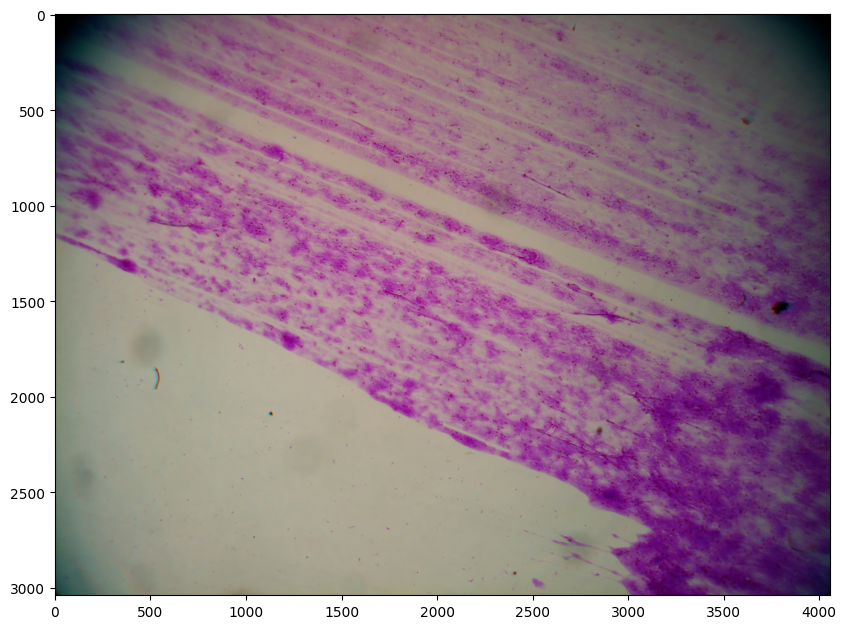

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(io.imread(path))
plt.show()

In [11]:
def brenner_gradient(image):
    return np.sum((image[2:]-image[:-2])**2)

In [13]:
path_in = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_5/sample_12/distance0.jpg"
path_out = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_5/sample_12/distance30.jpg"

In [ ]:
img_in = io.imread(path_in)
img_out = io.imread(path_out)

In [2]:
#path = "/home/maf4031/focus_model/data/test/same_test_dataset.pt"
path = "/home/maf4031/focus_model/data/jiang_datasets/dataset_patch_train.pt"

In [3]:
from src.test import TestDataset
from src.datamodules.components.jiang_dataset import PatchNewDataset
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split

In [4]:
d = torch.load(path)
d.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (1))])

In [5]:
data_train, data_val = random_split(
                dataset=d,
                lengths=[0.8, 0.2],
                generator=torch.Generator().manual_seed(42),
            )

In [6]:
len(data_val)

25739

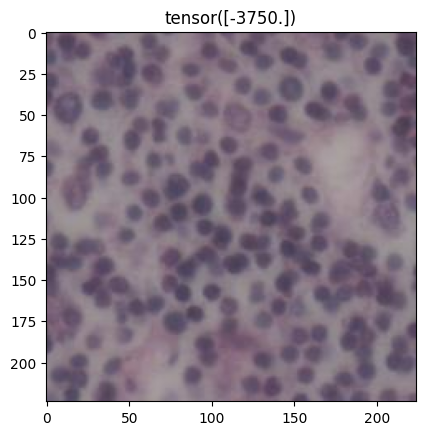

In [7]:
i = 1400
plt.imshow(d[i][0].numpy().squeeze().transpose(1, 2, 0))
plt.title(d[i][1])
plt.show()

In [99]:
from src.models.components.ynet_spectral import YNet_simplified as YNet_simplified_spectral
from src.models.components.ynet_simplified import YNet_simplified as YNet_simplified_mixed

In [98]:
state_dict.keys()

dict_keys(['encoder1.enc1conv1.weight', 'encoder1.enc1norm1.weight', 'encoder1.enc1norm1.bias', 'encoder1.enc1norm1.running_mean', 'encoder1.enc1norm1.running_var', 'encoder1.enc1norm1.num_batches_tracked', 'encoder1.enc1conv2.weight', 'encoder1.enc1norm2.weight', 'encoder1.enc1norm2.bias', 'encoder1.enc1norm2.running_mean', 'encoder1.enc1norm2.running_var', 'encoder1.enc1norm2.num_batches_tracked', 'encoder2.enc2conv1.weight', 'encoder2.enc2norm1.weight', 'encoder2.enc2norm1.bias', 'encoder2.enc2norm1.running_mean', 'encoder2.enc2norm1.running_var', 'encoder2.enc2norm1.num_batches_tracked', 'encoder2.enc2conv2.weight', 'encoder2.enc2norm2.weight', 'encoder2.enc2norm2.bias', 'encoder2.enc2norm2.running_mean', 'encoder2.enc2norm2.running_var', 'encoder2.enc2norm2.num_batches_tracked', 'encoder3.enc3conv1.weight', 'encoder3.enc3norm1.weight', 'encoder3.enc3norm1.bias', 'encoder3.enc3norm1.running_mean', 'encoder3.enc3norm1.running_var', 'encoder3.enc3norm1.num_batches_tracked', 'encoder3

In [101]:
ckpt_path = "/home/maf4031/focus_model/logs/wandb_sweep/runs/2023-03-08_15-23-37/checkpoints/epoch_148.ckpt"
device = torch.device("cpu")

model = YNet_simplified_mixed()
state_dict = torch.load(ckpt_path, map_location=device)['state_dict']
state_dict = {k.replace("net.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
_ = model.eval()

In [86]:
t = transforms.Compose([transforms.Normalize((0), (1))])

In [13]:
from tqdm import tqdm

error = []
for idx, (x,y, _) in enumerate(tqdm(data_val)):
    if idx == 100:
        break
    with torch.no_grad():  
        pred = model(x.unsqueeze(0))
        target = y
    error.append(abs(target-pred.item()))
print(np.mean(error))
    

  0%|          | 100/25739 [01:09<4:56:04,  1.44it/s]
/home/maf4031/.local/lib/python3.9/site-packages/numpy/core/_methods.py:165: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asanyarray(a)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

In [ ]:
# save error as npy
np.save("/home/maf4031/focus_model/data/jiang_datasets/error.npy", np.array(error))

In [58]:
import pandas as pd
import pickle
#df = pd.read_csv("/home/maf4031/focus_model/output/test_prediction.csv")
with open("/home/maf4031/focus_model/output/test_prediction.pkl", "rb") as f:
    df = pickle.load(f)

In [88]:
df['s104_l1_defocus-2800.jpg'].mean()

tensor(-449.7003)

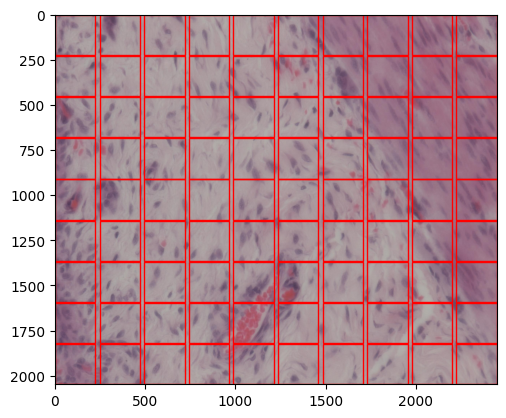

In [69]:
import matplotlib.patches as patches

protocol = "same"
data_path = f"/n/data2/hms/dbmi/kyu/lab/maf4031/incoherent_RGBchannels/testRawData_incoherent_{protocol}Protocol"  
img = 's104_l1/defocus-2800.jpg'

fig, ax = plt.subplots(1)
ax.imshow(io.imread(os.path.join(data_path, img)))

patch_size = (224, 224)
image_size = (2048, 2448)
h, w = image_size
x_steps = int(h / patch_size[0])
y_steps = int(w / patch_size[1])
x_coord = np.linspace(int(patch_size[0]/2), h - int(patch_size[0]/2), x_steps)
y_coord = np.linspace(int(patch_size[1]/2), w - int(patch_size[1]/2), y_steps)
patch_coords = [(x, y) for x in x_coord for y in y_coord]


for x, y in patch_coords:
    rect = patches.Rectangle((y-int(patch_size[1]/2), x-int(patch_size[0]/2)), patch_size[1], patch_size[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [61]:
df.keys()

dict_keys(['s104_l1_defocus-2800.jpg', 's104_l1_defocus-10300.jpg', 's104_l1_defocus-4800.jpg', 's104_l1_defocus5700.jpg', 's104_l1_defocus2200.jpg', 's104_l1_defocus-2300.jpg', 's104_l1_defocus-1800.jpg', 's104_l1_defocus-5800.jpg', 's104_l1_defocus8200.jpg', 's104_l1_defocus8700.jpg', 's104_l1_defocus7200.jpg', 's104_l1_defocus-1300.jpg', 's104_l1_defocus-8300.jpg', 's104_l1_defocus6700.jpg', 's104_l1_defocus-3800.jpg', 's104_l1_defocus4200.jpg', 's104_l1_defocus5200.jpg', 's104_l1_defocus3200.jpg', 's104_l1_defocus9200.jpg', 's104_l1_defocus-5300.jpg', 's104_l1_defocus-300.jpg', 's104_l1_defocus-7800.jpg', 's104_l1_defocus200.jpg', 's104_l1_defocus2700.jpg', 's104_l1_defocus-800.jpg', 's104_l1_defocus1700.jpg', 's104_l1_defocus3700.jpg', 's104_l1_defocus-10800.jpg', 's104_l1_defocus-8800.jpg', 's104_l1_defocus4700.jpg', 's104_l1_defocus700.jpg', 's104_l1_defocus-7300.jpg', 's104_l1_defocus-6300.jpg', 's104_l1_defocus-9800.jpg', 's104_l1_defocus1200.jpg', 's104_l1_defocus-4300.jpg', 

In [47]:
import copy 
a1 = d.array_images[:1000]
l1 = d.array_labels[:1000]
d1 = copy.deepcopy(d)

In [48]:
torch.save(d1, "/home/maf4031/focus_model/data/test/same_test_dataset_1000.pt")